In [2]:
from kb_utils import *

In [ ]:
create_kb()

### Feature engineering tramite KB

In [5]:
# derivo i nuovi dataframe dalla kb
prolog = Prolog()
prolog.consult('facts.pl')
prolog.consult('clauses.pl')

movies = pd.read_csv('../dataset/movies_v2.csv')

new_movies = derive_movies_data(movies, prolog)
new_movies.to_csv('../dataset/movies_new.csv', index=False)

directors = movies['director'].unique()
new_directors = derive_directors_data(directors, prolog)
new_directors.to_csv('../dataset/directors_new.csv', index=False)

actors = movies['star'].unique()
new_actors = derive_actors_data(actors, prolog)
new_actors.to_csv('../dataset/actors_new.csv', index=False)

In [3]:
df = pd.read_csv('../dataset/movies_v2.csv')

# nuove features per movies
df['age'] = 2024 - df['year']
df['profit_index'] = (df['gross'] - df['budget']) / df['budget']
df['success_index'] = df['profit_index'] * np.log(df['budget'])
df['cult_index'] = df['score'] * np.log(df['votes'])

def genre_regroup(genre):
    if genre in ['Mystery', 'Thriller', 'Sci-Fy', 'Family', 'Romance', 'Western']:
        return 'Others'
    return genre

df['genre'] = df['genre'].apply(genre_regroup)

def rating_regroup(rating):
    if rating in ['NC-17', 'TV-MA', 'Approved', 'X']:
        return 'Others'
    return rating

df['rating'] = df['rating'].apply(rating_regroup)

# nuove features per registi e attori
directors = df['director'].unique()
actors = df['star'].unique()

# creo i nuovi dataframe
directors_dict = {'director_name': directors}
df_directors = pd.DataFrame(directors_dict)

actors_dict = {'actor_name': actors}
df_actors = pd.DataFrame(actors_dict)


# derivo le nuove features
df_directors['director_num_movies'] = [len(df[df['director'] == name]) for name in df_directors['director_name']]

df_directors['director_profit_mean'] = [df[df['director'] == name]['profit_index'].mean() for name in df_directors['director_name']]

for name in df_directors.loc[df_directors['director_profit_mean'].isnull(), 'director_name']:
    df_directors.loc[df_directors['director_name'] == name, 'director_profit_mean'] = df[df['director'] == name]['profit_index']

df_directors['director_profit_std'] = [df[df['director'] == name]['profit_index'].std() for name in df_directors['director_name']]

df_directors['director_profit_std'] = df_directors['director_profit_std'].fillna(0)

df_directors['director_score_mean'] = [df[df['director'] == name]['score'].mean() for name in df_directors['director_name']]

for name in df_directors.loc[df_directors['director_score_mean'].isnull(), 'director_name']:
    df_directors.loc[df_directors['director_name'] == name, 'director_score_mean'] = df[df['director'] == name]['score']

df_directors['director_score_std'] = [df[df['director'] == name]['score'].std() for name in df_directors['director_name']]

df_directors['director_score_std'] = df_directors['director_score_std'].fillna(0)

df_actors['actor_num_movies'] = [len(df[df['star'] == name]) for name in df_actors['actor_name']]

df_actors['actor_profit_mean'] = [df[df['star'] == name]['profit_index'].mean() for name in df_actors['actor_name']]

for name in df_actors.loc[df_actors['actor_profit_mean'].isnull(), 'actor_name']:
    df_actors.loc[df_actors['actor_name'] == name, 'actor_profit_mean'] = df[df['star'] == name]['profit_index']

df_actors['actor_profit_std'] = [df[df['star'] == name]['profit_index'].std() for name in df_actors['actor_name']]

df_actors['actor_profit_std'] = df_actors['actor_profit_std'].fillna(0)

df_actors['actor_score_mean'] = [df[df['star'] == name]['score'].mean() for name in df_actors['actor_name']]

for name in df_actors.loc[df_actors['actor_score_mean'].isnull(), 'actor_name']:
    df_actors.loc[df_actors['actor_name'] == name, 'actor_score_mean'] = df[df['star'] == name]['score']

df_actors['actor_score_std'] = [df[df['star'] == name]['score'].std() for name in df_actors['actor_name']]

df_actors['actor_score_std'] = df_actors['actor_score_std'].fillna(0)



df_directors.to_csv('../dataset/directors_new.csv', index=False)
df_actors.to_csv('../dataset/actors_new.csv', index=False)
df.to_csv('../dataset/movies_new.csv', index=False)

In [4]:
df_directors = pd.read_csv('../dataset/directors_new.csv')
df_actors = pd.read_csv('../dataset/actors_new.csv')
df = pd.read_csv('../dataset/movies_new.csv')

# join finale tra i dataset
df = df.merge(df_directors, left_on='director', right_on='director_name', how='left')
df = df.merge(df_actors, left_on='star', right_on='actor_name', how='left')

df = df.drop(['director_name', 'actor_name'], axis=1)

df.to_csv('../dataset/movies_final_v1.csv', index=False)

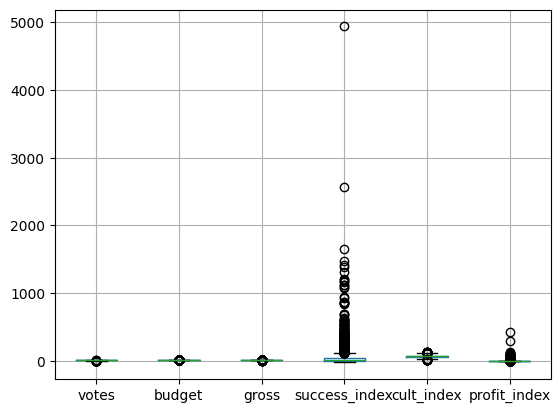

In [17]:
import pandas as pd
import numpy as np

df = pd.read_csv('../dataset/movies_final_v1.csv')

df['votes'] = np.log(df['votes'])
df['budget'] = np.log(df['budget'])
df['gross'] = np.log(df['gross'])

import matplotlib.pyplot as plt

df = df[df['success_index'] < 40000]

# visualizza il box plot delle colonne votes budget e gross e anche le colonne success_index, cult_index e profit_index
df.boxplot(['votes', 'budget', 'gross', 'success_index', 'cult_index', 'profit_index'])
plt.show()

In [18]:
df = pd.read_csv('../dataset/movies_final_v1.csv')

def names(col):
    if col == 0:
        return 'low'
    elif col == 1:
        return 'mid-low'
    elif col == 2:
        return 'mid-high'
    elif col == 3:
        return 'high'

def bin_naming(df, cols):
    for col in cols:
        df[col + '_bin'] = df[col].apply(names) 

def bin_votes(votes):
    if votes < df['votes'].quantile(0.25):
        return 0
    elif votes < df['votes'].quantile(0.5):
        return 1
    elif votes < df['votes'].quantile(0.75):
        return 2
    elif votes > df['votes'].quantile(0.75):
        return 3
    
def bin_budget(budget):
    if budget < df['budget'].quantile(0.25):
        return 0
    elif budget < df['budget'].quantile(0.5):
        return 1
    elif budget < df['budget'].quantile(0.75):
        return 2
    elif budget > df['budget'].quantile(0.75):
        return 3
    
def bin_gross(gross):
    if gross < df['gross'].quantile(0.25):
        return 0
    elif gross < df['gross'].quantile(0.5):
        return 1
    elif gross < df['gross'].quantile(0.75):
        return 2
    elif gross > df['gross'].quantile(0.75):
        return 3
    
def bin_profit_index(profit_index):
    if profit_index < df['profit_index'].quantile(0.25):
        return 0
    elif profit_index < df['profit_index'].quantile(0.5):
        return 1
    elif profit_index < df['profit_index'].quantile(0.75):
        return 2
    elif profit_index > df['profit_index'].quantile(0.75):
        return 3
    
def bin_cult_index(cult_index):
    if cult_index < df['cult_index'].quantile(0.25):
        return 0
    elif cult_index < df['cult_index'].quantile(0.5):
        return 1
    elif cult_index < df['cult_index'].quantile(0.75):
        return 2
    elif cult_index > df['cult_index'].quantile(0.75):
        return 3
    
def bin_runtime(runtime):
    if runtime < 90:
        return 0
    elif runtime > 150:
        return 2
    else:
        return 1
    
def bin_age(age):
    if age < 15:
        return 0
    elif age > 35:
        return 2
    else:
        return 1
    
df['votes'] = np.log(df['votes'])

df['votes'] = df['votes'].apply(bin_votes)

df['budget'] = np.log(df['budget'])

df['budget'] = df['budget'].apply(bin_budget)

df['gross'] = np.log(df['gross'])

df['gross'] = df['gross'].apply(bin_gross)

df['profit_index'] = df['profit_index'].apply(bin_profit_index)

df['cult_index'] = df['cult_index'].apply(bin_cult_index)

df['runtime'] = df['runtime'].apply(bin_runtime)

df['age'] = df['age'].apply(bin_age)

bin_naming(df, ['votes', 'budget', 'gross', 'profit_index', 'cult_index', 'runtime', 'age'])

df = df.drop(columns=['year', 'votes', 'budget', 'gross', 'profit_index', 'cult_index', 'runtime', 'age'], axis=1)

df.to_csv('../dataset/movies_final_v2.csv', index=False)



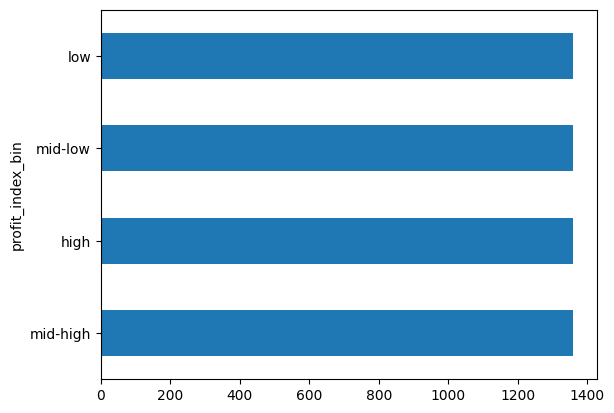

In [24]:
df = pd.read_csv('../dataset/movies_final_v2.csv')

df['profit_index_bin'].value_counts().plot.barh()
plt.show()